### Data imputation

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.convolution import interpolate_replace_nans, Kernel

import sys
sys.path.append('../conv_imputer')
import gen_synth
import impute_weekly

#### Generate the data set

In [231]:
data = gen_synth.weekly_daily_signal()

E:\Python\HRI\convolution-imputation\research\../conv_imputer\gen_synth.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=24*7*num_weeks, freq='H')


In [233]:
# data

In [234]:
# Shape of the dataset
print("Shape of the dataset:", data.shape)
# Number of NaN values
print("Total number of NaN values:", np.isnan(data).sum())

Shape of the dataset: (672,)
Total number of NaN values: 0


In [235]:
# This function pivots time-series data into a weekly format with time-of-week as columns, replacing placeholder values with NaN.
def get_pivoted_weekly(data):
    df = pd.DataFrame(data)
    df["updatetime"]  = data.index
    df["week_start"] = df["updatetime"].dt.to_period('W-SUN').apply(lambda r: r.start_time)
    df["tow"] = df['updatetime'] - df['week_start']
    pivoted = pd.pivot_table(df, values = 0, index=['week_start'], columns = 'tow').reset_index()
    return pivoted.replace(-666,np.nan)

In [ ]:
# Generate a synthetic missing pattern
missing_pattern = gen_synth.uniform_random_missing_patterns(get_pivoted_weekly(data).iloc[:,1:], num_patterns=1, num_missings=30)
# Set missing values
missing = data.copy()
missing.iloc[missing_pattern[0].flatten().nonzero()] = np.nan

In [237]:
missing = data.copy()
# List of positions to set to NaN
nan_positions = [0, 23, 24, 47, 48, 71, 120, 143, 144, 167, 264, 287, 288, 311, 312, 335, 408, 431, 432, 455, 456, 479, 480, 503, 576, 599, 624, 647, 648, 671]
# Set these positions to NaN
missing.iloc[nan_positions] = np.nan

In [238]:
print("Total number of NaN values in 'data':", np.isnan(data).sum())
print("Total number of NaN values in 'missing':", np.isnan(missing).sum())

Total number of NaN values in 'data': 0
Total number of NaN values in 'missing': 30


In [239]:
# Create a DataFrame from the provided data
data_df = pd.DataFrame(data)
# Add a new column "updatetime" to the DataFrame using the index of the data
data_df["updatetime"] = data_df.index
# Rename the column with key 0 to "value"
data_df.rename(columns={0: 'value'}, inplace=True)

In [241]:
# data_df

In [242]:
missing_df = pd.DataFrame(missing)
missing_df["updatetime"] = missing_df.index
missing_df.rename(columns={0: 'value'}, inplace=True)

In [243]:
# missing_df

In [244]:
# Define dimensions
hours_per_day = 24
days_per_week = 7
weeks = len(data) // (hours_per_day * days_per_week)
# weeks = len(missing) // (hours_per_day * days_per_week)

In [245]:
data_values = data_df['value'].to_numpy()
data_array = data_values.reshape((weeks, days_per_week, hours_per_day))

In [246]:
missing_values = missing_df['value'].to_numpy()
missing_array = missing_values.reshape((weeks, days_per_week, hours_per_day))

In [247]:
# missing_array

In [248]:
print("Shape of 3D array in data:", data_array.shape)
print("Shape of 3D array in missing:", missing_array.shape)
print("Total number of NaN values in 'data_df':", np.isnan(data_df['value']).sum())
print("Total number of NaN values in 'missing_df':", np.isnan(missing_df['value']).sum())

Shape of 3D array in data: (4, 7, 24)
Shape of 3D array in missing: (4, 7, 24)
Total number of NaN values in 'data_df': 0
Total number of NaN values in 'missing_df': 30


#### 3D Gaussian kernel

In [249]:
class CustomGaussian3DKernel(Kernel):
    def __init__(self, size_x, size_y, size_z, stddev_x, stddev_y, stddev_z):
        """
        Create a 3D Gaussian kernel with customizable sizes and standard deviations.
        
        Parameters:
        size_x, size_y, size_z: int
            Sizes of the kernel along x, y, z axes.
        stddev_x, stddev_y, stddev_z: float
            Standard deviations of the Gaussian along x, y, z axes.
        """
        # Create 3D grids for the coordinates (x,y,z) centered around 0
        x, y, z = np.meshgrid(
            np.linspace(-size_x // 2, size_x // 2, size_x), # Generate linearly spaced values for creating a grid for each axis
            np.linspace(-size_y // 2, size_y // 2, size_y),
            np.linspace(-size_z // 2, size_z // 2, size_z),
            indexing='ij', # Ensure the output is in matrix indexing format
        )
        kernel = np.exp(
            -((x**2) / (2 * stddev_x**2) + (y**2) / (2 * stddev_y**2) + (z**2) / (2 * stddev_z**2))
        )
        kernel /= np.sum(kernel)  # Normalize the kernel
        super().__init__(array=kernel)

In [250]:
# Define the dimensions and standard deviations for the Gaussian kernel
x_size = 3 # Weekly (the depth of the cube; front to back)
y_size = 3 # Daily (the height of the cube; top to bottom)
z_size = 3 # Hourly (width of the cube; left to right)
x_stddev = 1
y_stddev = 1
z_stddev = 1

# Initialize a custom 3D Gaussian kernel with the specified dimensions and standard deviations
kernel = CustomGaussian3DKernel(x_size, y_size, z_size, x_stddev, y_stddev, z_stddev)

In [251]:
# Actual values of the 3D Gaussian kernel
kernel_array = kernel.array
# kernel_array

In [252]:
# Sum all the elements in the kernel array
kernel_sum = kernel_array.sum()  # Since the values in a Gaussian kernel are typically normalized, the sum should ideally be 1.
kernel_sum

0.9999999999999999

#### Missing value imputation

In [253]:
# Define the pad width
pad_width = max(kernel.shape[0], kernel.shape[1], kernel.shape[2]) // 3
# Pad the input array
padded = np.pad(missing_array.copy(), mode='edge', pad_width=pad_width)

In [262]:
# Apply the 'interpolate_replace_nans' function to impute missing values
imputed = interpolate_replace_nans(padded, kernel)
# Calculate the slicing indices to remove padding
slices = tuple(slice(pad_width, -pad_width) for _ in range(missing_array.ndim))
# Extract the imputed array without padding
missing_imputed = imputed[slices]

# Verify that the shapes match
assert imputed_no_padding.shape == missing_array.shape, "The shapes do not match!"

print("Total number of NaN values in 'missing_array':", np.isnan(missing_array).sum())
print("Total number of NaN values in 'missing_imputed':", np.isnan(missing_imputed).sum())

Total number of NaN values in 'missing_array': 30
Total number of NaN values in 'missing_imputed': 0


In [263]:
# Identify missing indices
missing_indices = np.isnan(missing_array)
# Extract imputed and ground truth values
imputed_values = missing_imputed[missing_indices]
actual_values = data_array[missing_indices]
# Calculate RMSE
rmse = np.sqrt(np.mean((imputed_values - actual_values) ** 2))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.5017


#### Conversion from arrays to DataFrame

In [264]:
# Flatten the 3D array back to a 1D array
imputed_flattened = missing_imputed.ravel()
# Update the 'value' column in the original DataFrame
missing_df['value_imputed'] = imputed_flattened
# Add the actual values in the original DataFrame
missing_df['value_actual'] = data_df['value']

In [265]:
# Extract rows where 'value' is missing (NaN)
missing_rows = missing_df[missing_df['value'].isna()]

In [267]:
# missing_rows

,value,updatetime,value_imputed,value_actual
2023-01-02 00:00:00,NaN,2023-01-02 00:00:00,4.168275,4.000000
2023-01-02 23:00:00,NaN,2023-01-02 23:00:00,3.772538,4.117366
2023-01-03 00:00:00,NaN,2023-01-03 00:00:00,4.320057,4.405321
2023-01-03 23:00:00,NaN,2023-01-03 23:00:00,3.357778,3.503762
2023-01-04 00:00:00,NaN,2023-01-04 00:00:00,3.549727,3.752407
2023-01-04 23:00:00,NaN,2023-01-04 23:00:00,2.306081,2.290260
2023-01-07 00:00:00,NaN,2023-01-07 00:00:00,1.751461,1.802551
2023-01-07 23:00:00,NaN,2023-01-07 23:00:00,1.705185,2.496329
2023-01-08 00:00:00,NaN,2023-01-08 00:00:00,2.722218,2.841658
2023-01-08 23:00:00,NaN,2023-01-08 23:00:00,2.845878,3.669016


In [266]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
mean_squared_error(missing_rows['value_actual'], missing_rows['value_imputed'], squared=False)

D:\Apps\Anaconda\envs\HRI\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.5016803324268485

#### RMSE for multiple values of `pad_width`

In [270]:
def calculate_rmse_for_pad_widths(missing_array, data_array, kernel, max_pad_width=12):
    """
    Calculate RMSE for multiple pad_width values.

    Parameters:
        missing_array (np.ndarray): The input array with missing values.
        data_array (np.ndarray): The ground truth array without missing values.
        kernel (np.ndarray): The kernel to use in `interpolate_replace_nans`.
        max_pad_width (int): The maximum pad_width to test (default is 12).

    Returns:
        dict: A dictionary mapping pad_width to its corresponding RMSE.
    """
    rmse_results = {}

    for pad_width in range(1, max_pad_width + 1):
        # Pad the input array
        padded = np.pad(missing_array.copy(), mode='edge', pad_width=pad_width)

        # Apply the interpolation function (replace this with your function)
        imputed = interpolate_replace_nans(padded, kernel)

        # Calculate the slicing indices to remove padding
        slices = tuple(slice(pad_width, -pad_width) for _ in range(missing_array.ndim))

        # Extract the imputed array without padding
        missing_imputed = imputed[slices]

        # Identify missing indices
        missing_indices = np.isnan(missing_array)

        # Extract imputed and ground truth values
        imputed_values = missing_imputed[missing_indices]
        actual_values = data_array[missing_indices]

        # Calculate RMSE
        rmse = np.sqrt(np.mean((imputed_values - actual_values) ** 2))

        # Store the result
        rmse_results[pad_width] = rmse

        # Print the RMSE for the current pad_width
        print(f"pad_width: {pad_width}, RMSE: {rmse:.4f}")

    return rmse_results

In [229]:
rmse_results = calculate_rmse_for_pad_widths(missing_array, data_array, kernel)

pad_width: 1, RMSE: 0.3733
pad_width: 2, RMSE: 0.3733
pad_width: 3, RMSE: 0.3733
pad_width: 4, RMSE: 0.3733
pad_width: 5, RMSE: 0.3733
pad_width: 6, RMSE: 0.3733
pad_width: 7, RMSE: 0.3733
pad_width: 8, RMSE: 0.3733
pad_width: 9, RMSE: 0.3733
pad_width: 10, RMSE: 0.3733
pad_width: 11, RMSE: 0.3733
pad_width: 12, RMSE: 0.3733


In [271]:
rmse_results = calculate_rmse_for_pad_widths(missing_array, data_array, kernel)

pad_width: 1, RMSE: 0.5016803324268485
pad_width: 2, RMSE: 0.5016803324268485
pad_width: 3, RMSE: 0.5016803324268485
pad_width: 4, RMSE: 0.5016803324268485
pad_width: 5, RMSE: 0.5016803324268485
pad_width: 6, RMSE: 0.5016803324268485
pad_width: 7, RMSE: 0.5016803324268485
pad_width: 8, RMSE: 0.5016803324268485
pad_width: 9, RMSE: 0.5016803324268485
pad_width: 10, RMSE: 0.5016803324268485
pad_width: 11, RMSE: 0.5016803324268485
pad_width: 12, RMSE: 0.5016803324268485


#### Trial: Reshape into a 3D array

In [77]:
# Example DataFrame with only 'value'
df_trial = pd.DataFrame({
    "value": range(1, 24*7*4 + 1)  # Simulating data points for 4 weeks
})

# Define dimensions
hours_per_day = 24
days_per_week = 7
weeks = len(df_trial) // (hours_per_day * days_per_week)

# Check if the data length matches the full weeks of data
if len(df_trial) % (hours_per_day * days_per_week) != 0:
    raise ValueError("The number of data points must be a multiple of 24 * 7 (hours * days per week).")

In [80]:
# Reshape the 'value' column into a 3D array
values_trial = df_trial['value'].to_numpy()
data_trial = values_trial.reshape((weeks, days_per_week, hours_per_day))

# Verification of the structure
print("Shape of 3D array:", data_trial.shape)  # Should be (weeks, days_per_week, hours_per_day)
print("Example data point [1,1,1]:", data_trial[0, 0, 0])  # Corresponds to the start of the first week
print("Example data point [2,1,1]:", data_trial[1, 0, 0])  # Corresponds to the start of the second week

Shape of 3D array: (4, 7, 24)
Example data point [1,1,1]: 1
Example data point [2,1,1]: 169


In [82]:
# data_trial

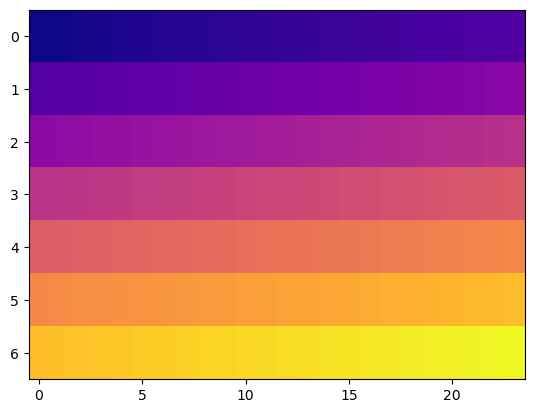

In [88]:
plt.imshow(data_trial[0,::,::], aspect="auto", cmap="plasma") # Extracts a 2D array representing all days (rows) and all hours (columns) for the first week.

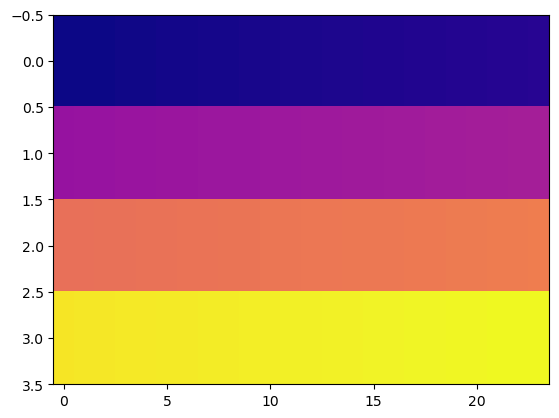

In [90]:
plt.imshow(data_trial[::,0,::], aspect="auto", cmap="plasma") # Extracts a 2D array representing the hours of the first day in each week (from 1 to 24).
# x-axis (columns): Represents the hours of the first day in each week (from 1 to 24).
# y-axis (rows): Represents the weeks.
# Color intensity: Represents the values from the array corresponding to each hour on the first day of each week.

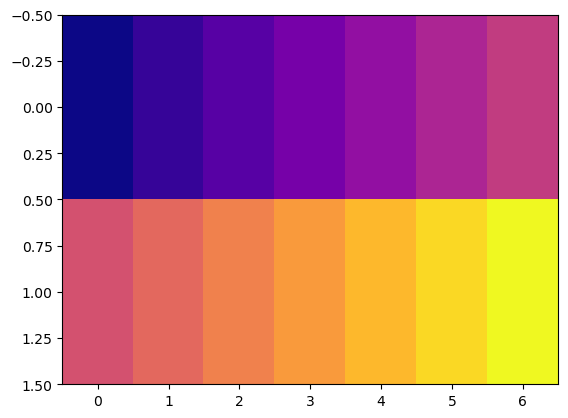

In [91]:
plt.imshow(data_3d[::,::,0], aspect="auto", cmap="plasma")
# x-axis (columns): Represents the days in a week (from 1 to 7).
# y-axis (rows): Represents the weeks.
# Color intensity: Represents the values for the first hour (Hour 1) on each day, across all weeks.